In [ ]:
import os
os.chdir('/content/drive/MyDrive/workspace/Learning_Equality')

In [ ]:
!nvidia-smi

Mon Jan  9 03:03:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install cudf-cu11 dask-cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
!pip install cuml-cu11 --extra-index-url=https://pypi.ngc.nvidia.com

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 111.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.6/453.6 KB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 923.4/923.4 KB 51.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: proto

In [ ]:
!pip install -U transformers
!pip install sentencepiece
!pip install -U fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoTokenizer, AutoConfig, AutoModel
import gc
import tqdm
import cudf
from cuml.neighbors import NearestNeighbors
from cuml.datasets import make_blobs
from sklearn.model_selection import KFold
from fuzzywuzzy import fuzz, process
import time
import seaborn as sns

/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# データフレームをロードする
topics_df = pd.read_csv('./data/row/topics.csv')
content_df = pd.read_csv('./data/row/content.csv')
correlations_df = pd.read_csv('./data/row/correlations.csv')
sample_submission = pd.read_csv('./data/row/sample_submission.csv')

In [ ]:
class CFG:
  MODEL_NAME = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
  DEVICE = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
  SEED=42
  TRAIN_STEP = True
  N_NEIGHBORS = 1000

In [ ]:
content_df = content_df.fillna('')
topics_df = topics_df.fillna('')

In [ ]:
topics_df = topics_df[topics_df.has_content].reset_index(drop=True)
topics_df.drop(['description', 'channel', 'category', 'level', 'parent', 'has_content'], axis = 1, inplace = True)
content_df.drop(['description', 'kind',  'text', 'copyright_holder', 'license'], axis = 1, inplace = True)

In [ ]:
def get_train_test_data(train):
    train_idx = topics_df[~topics_df.id.isin(sample_submission.topic_id)].index
    train["fold"] = -1
    # 交差検証 用の番号を振ります。
    kf = KFold(n_splits=5, shuffle=True, random_state=CFG.SEED)
    for n, (train_index, val_index) in enumerate(kf.split(train_idx)):
        train.loc[train_idx[val_index], "fold"] = int(n)
    train["fold"] = train["fold"]
    return train
topics_df = get_train_test_data(topics_df)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_NAME, use_fast=True)
model = AutoModel.from_pretrained(CFG.MODEL_NAME)

Downloading:   0%|          | 0.00/402 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/723 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
def get_embeddings(tokenizer, data:pd.Series):
    data = list(data.fillna(''))
    gap = 1000
    
    token_outs = []
    # uniform dynamic padding
    for i in tqdm.tqdm(range(0, len(data), gap), desc='tokenization'):
        batch_tokens=tokenizer(data[i:i+gap], truncation=True, padding=True, return_tensors='pt')
        token_outs.append(batch_tokens)
        
    outs = []
    model.to(CFG.DEVICE)
    model.eval()
    
    with torch.no_grad():
        for batch_tokens in tqdm.tqdm(token_outs, total=len(token_outs), desc='model output'):
            inputs = batch_tokens['input_ids'].to(CFG.DEVICE)
            attention_mask = batch_tokens['attention_mask'].to(CFG.DEVICE)
            out = model(inputs, attention_mask=attention_mask).last_hidden_state.mean(1)
            outs.append(out.cpu().numpy())
    return np.concatenate(outs)

In [ ]:
save_name = f"./data/processed/content_title_emb_{CFG.MODEL_NAME.split('/')[1]}.npy"
try:
  contents_embedding = np.load(save_name)
except:
  contents_embedding = get_embeddings(tokenizer, content_df.title)
  np.save(save_name, contents_embedding)

In [ ]:
save_name = f"./data/processed/topics_title_emb_{CFG.MODEL_NAME.split('/')[1]}.npy"
try:
  topics_embedding = np.load(save_name)
except:
  topics_embedding = get_embeddings(tokenizer, topics_df.title)
  np.save(save_name, topics_embedding)

In [ ]:
topics_embedding_cudf = cudf.DataFrame(topics_embedding)
del topics_embedding
gc.collect()

30

In [ ]:
topics_df

,id,title,language,fold
0,t_00004da3a1b2,Откриването на резисторите,bg,-1
1,t_00068291e9a4,Entradas e saídas de uma função,pt,-1
2,t_00069b63a70a,Transcripts,en,-1
3,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,bg,-1
4,t_0008768bdee6,100 સુધીનો સરવાળો,gu,1
...,...,...,...,...
61512,t_fff830472691,Scalar Projections,en,2
61513,t_fff9e5407d13,NA_U06 - El periódico,es,4
61514,t_fffbe1d5d43c,Inscribed shapes problem solving,sw,2
61515,t_fffe14f1be1e,Lección 7,es,2


In [ ]:
all_topics_lang = topics_df.language.to_numpy()
all_content_lang  =  content_df.language.to_numpy()
lang_list = np.unique(all_topics_lang)
knn_prd_idx = []
knn_prd_dis = []
for lang in lang_list:
    prd_data = topics_embedding_cudf[all_topics_lang==lang]
    fit_data = contents_embedding[all_content_lang==lang]
    print(f"言語:{lang}, コンテンツ数:{fit_data.shape[0]}, トピック数:{prd_data.shape[0]}")
    content_idx = np.where(all_content_lang==lang)[0]
    if fit_data.shape[0]>CFG.N_NEIGHBORS:
      n_neighbors= CFG.N_NEIGHBORS
    else:
      n_neighbors=int(fit_data.shape[0])
    model = NearestNeighbors(n_neighbors=n_neighbors)
    model.fit(fit_data) 
    prd_dis, prd_idx = model.kneighbors(prd_data)
    prd_idx.index=prd_data.index
    prd_idx = prd_idx.to_pandas().applymap(lambda x:content_idx[x])
    knn_prd_idx.append(prd_idx)
    del prd_data, fit_data, content_idx, prd_idx
knn_prd_idx = pd.concat(knn_prd_idx, axis=0).sort_index()
gc.collect()

言語:ar, コンテンツ数:7418, トピック数:3173
言語:as, コンテンツ数:641, トピック数:126
言語:bg, コンテンツ数:6050, トピック数:2420
言語:bn, コンテンツ数:2513, トピック数:1731
言語:en, コンテンツ数:65939, トピック数:28053
言語:es, コンテンツ数:30844, トピック数:11769
言語:fil, コンテンツ数:516, トピック数:224
言語:fr, コンテンツ数:10682, トピック数:3034
言語:gu, コンテンツ数:3677, トピック数:1809
言語:hi, コンテンツ数:4042, トピック数:1373
言語:it, コンテンツ数:1300, トピック数:722
言語:km, コンテンツ数:505, トピック数:104
言語:kn, コンテンツ数:501, トピック数:88
言語:mr, コンテンツ数:999, トピック数:239
言語:my, コンテンツ数:206, トピック数:110
言語:or, コンテンツ数:326, トピック数:51
言語:pl, コンテンツ数:319, トピック数:28
言語:pnb, コンテンツ数:184, トピック数:40
言語:pt, コンテンツ数:10435, トピック数:3425
言語:ru, コンテンツ数:188, トピック数:21
言語:sw, コンテンツ数:1447, トピック数:2082
言語:swa, コンテンツ数:495, トピック数:33
言語:ta, コンテンツ数:216, トピック数:44
言語:te, コンテンツ数:285, トピック数:66
言語:tr, コンテンツ数:225, トピック数:26
言語:ur, コンテンツ数:245, トピック数:54
言語:zh, コンテンツ数:3849, トピック数:672


55622

In [ ]:
knn_prd_idx

NameError: ignored

In [ ]:
knn_prd_idx.iloc[topics_df[topics_df.id.isin(sample_submission.topic_id)].index,]

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,77473,66858,104675,101115,19262,20437,6197,143252,650,86138,...,18877.0,71561.0,62339.0,24676.0,2217.0,42369.0,56571.0,769.0,38207.0,28397.0
1,140002,82975,15208,100714,107462,1940,79774,67613,9041,109902,...,19687.0,110024.0,22131.0,104594.0,7670.0,118404.0,48183.0,126010.0,149026.0,1995.0
2,40399,83011,4669,150902,92463,64303,140725,23543,100533,153733,...,32796.0,122124.0,52413.0,144122.0,151198.0,142844.0,90869.0,19559.0,144060.0,126333.0
3,56779,123692,73185,93908,20892,59076,502,109932,75776,92673,...,45174.0,141639.0,66071.0,35824.0,153261.0,75102.0,4939.0,107679.0,129074.0,104553.0
15278,32922,63735,130,49945,90395,77447,53567,80296,119243,146565,...,103181.0,143001.0,57132.0,103423.0,137293.0,18074.0,104939.0,100813.0,65819.0,133250.0


In [ ]:
all_content_lang = content_df.language.to_numpy()
all_content_title = content_df.title.to_numpy()
all_content_ids =  content_df.id.to_numpy()
all_topics_lang = topics_df.language.to_numpy()
all_topics_title = topics_df.title.to_numpy()
all_topics_ids = topics_df.id.to_numpy()
preds = []
for t_idx in tqdm.tqdm(range(len(knn_prd_idx)), total=len(knn_prd_idx)):
  topic_id = all_topics_ids[t_idx]
  content_idx = knn_prd_idx.iloc[t_idx].to_numpy()
  content_idx = content_idx[~np.isnan(content_idx)].astype(int)
  content_ids = all_content_ids[content_idx]
  preds.append({
        'topic_id': topic_id,
        'content_ids': ' '.join(content_ids)
    })
preds = pd.DataFrame.from_records(preds)

100%|██████████| 61517/61517 [00:44<00:00, 1381.22it/s]


In [ ]:
del content_idx, knn_prd_idx,knn_prd_dis
gc.collect()

0

In [ ]:
preds['fold'] = topics_df['fold']

In [ ]:
preds

,topic_id,content_ids,fold
0,t_00004da3a1b2,c_80e7e76ff4db c_6f1dcaa3ca40 c_adb20c7622ac c...,-1
1,t_00068291e9a4,c_e88be716634d c_89ce9367be10 c_195aea2fb27f c...,-1
2,t_00069b63a70a,c_430ddb6fbfa4 c_89dee4e1d740 c_07e16f3aabbf c...,-1
3,t_0006d41a73a8,c_5e375cf14c47 c_cd77235f4115 c_79ccad92ad9e c...,-1
4,t_0008768bdee6,c_98a3be795988 c_15dbfe4c4b7f c_a054a9c041a7 c...,1
...,...,...,...
61512,t_fff830472691,c_61fb63326e5d c_8f224e321c87 c_5dd92e52bedb c...,2
61513,t_fff9e5407d13,c_e40fd6243440 c_d64037a72376 c_20de77522603 c...,4
61514,t_fffbe1d5d43c,c_d372244f5861 c_d101d147a0c6 c_4adc8c015f70 c...,2
61515,t_fffe14f1be1e,c_f28704d03be0 c_f2b100fd2ede c_871e131f762d c...,2


In [ ]:
# SVM用のデータセットを作成する
preds_stack = preds.content_ids.str.split(' ', expand=True).stack().to_frame().reset_index(level=1)

In [ ]:
preds_stack = preds_stack.rename(columns={0:'content_id'})
preds_stack = preds_stack.drop(columns=['level_1'])
preds_stack = preds_stack.join(preds).drop(columns=['content_ids'])

In [ ]:
correlations_df = correlations_df[correlations_df.topic_id.isin(topics_df.id)].reset_index(drop=True)

In [ ]:
all_fold = preds.fold
all_knn_prediction = preds.content_ids.apply(lambda x:np.array(x.split(' '))).to_list()
all_correlation_contents = correlations_df.content_ids.apply(lambda x:np.array(x.split(' '))).to_list()

In [ ]:
labels = []
for i in tqdm.tqdm(range(len(all_knn_prediction)), total=len(all_knn_prediction)):
    correlation_contents = all_correlation_contents[i]
    knn_prediction = all_knn_prediction[i]
    if all_fold[i]!=-1:
        label = np.isin(knn_prediction, correlation_contents)
        labels.append(label)
    else:
        labels.append(np.array([-1] * len(knn_prediction)))
labels = np.concatenate(labels)
preds_stack['label'] = labels

100%|██████████| 61517/61517 [00:04<00:00, 12554.26it/s]


In [ ]:
preds['true_content_ids'] = correlations_df["content_ids"]

In [ ]:
import seaborn as sns
def calc_cm(df, target_col, pred_col):
  prd = df[pred_col].apply(lambda x:x.split()).to_list()
  target = df[target_col].apply(lambda x:x.split()).to_list()
  res = {'TP':0, 'TN':0, 'FP':0, 'FN':0}
  for p, t in tqdm.tqdm(zip(prd, target), total=len(prd)):
    true_positives = len(set(t)&set(p))
    true_negtives = 154047 -len((set(p) | set(t))-(set(t)&set(p)))
    false_positives = len(set(p)-set(t))
    false_negatives = len(set(t)-set(p))
    res['TP'] += true_positives
    res['TN'] += true_negtives
    res['FP'] += false_positives
    res['FN'] += false_negatives
  return res
res = calc_cm(preds, 'true_content_ids','content_ids')

100%|██████████| 61517/61517 [00:15<00:00, 4077.36it/s]


In [ ]:
def calc_score(true_ids, pred_ids):
  true_positives = len(set(true_ids)&set(pred_ids))
  false_negatives = len(set(true_ids)-set(pred_ids))
  return true_positives/(true_positives + false_negatives)
def calc_score_mean(target_df, pred_df):
  shape = target_df.shape
  score = [calc_score(target_df.loc[i, 'content_ids'].split(), pred_df.loc[i, 'content_ids'].split()) for i in range(shape[0])]
  pred_df['score'] = score
  return pred_df['score'].mean(), pred_df
score, t_df = calc_score_mean(correlations_df, preds)

In [ ]:
topics_index2id = topics_df.id.to_dict()
topics_id2index = dict(zip(topics_index2id.values(), topics_index2id.keys()))
contents_index2id = content_df.id.to_dict()
contents_id2index = dict(zip(contents_index2id.values(), contents_index2id.keys()))

In [ ]:
contents_embedding_cudf = cudf.DataFrame(contents_embedding)

In [ ]:
train_df = preds_stack[preds_stack.fold!=-1].reset_index(drop=False)
test_df = preds_stack[preds_stack.fold==-1].reset_index(drop=False)
train_to_idx = train_df.topic_id.apply(lambda x:topics_id2index[x]).to_numpy()
train_co_idx = train_df.content_id.apply(lambda x:contents_id2index[x]).to_numpy()
test_to_idx = test_df.topic_id.apply(lambda x:topics_id2index[x]).to_numpy()
test_co_idx = test_df.content_id.apply(lambda x:contents_id2index[x]).to_numpy()
del preds_stack
gc.collect()

0

In [ ]:
path = '/content/drive/MyDrive/workspace/Learning_Equality/data/row/train_data'
train_df.to_csv(Path(path) / "train_df.csv")
topics_embedding_cudf

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.042328,-0.019342,-0.021062,0.068511,0.031034,-0.043406,0.045507,0.016037,0.046802,0.046290,...,0.002685,-0.082168,0.025355,0.013601,-0.013052,0.099037,-0.025383,0.091100,-0.054960,-0.096438
1,-0.064115,-0.108731,-0.020388,0.066358,0.034825,-0.069933,-0.077625,-0.009777,-0.030357,0.107966,...,0.044562,-0.038454,-0.046050,-0.000530,-0.029337,-0.044206,-0.070432,0.071556,0.028432,-0.112295
2,-0.090753,-0.047007,-0.018146,0.051810,-0.016103,-0.047351,0.053161,-0.000833,-0.148703,-0.007953,...,0.043128,-0.045755,0.013478,-0.063475,-0.034895,0.038652,0.040359,0.049306,-0.035913,-0.133557
3,-0.151605,-0.130497,-0.018439,0.145702,0.001998,-0.007427,-0.026879,0.023504,0.082751,0.048634,...,-0.046298,0.002464,0.004665,-0.096869,-0.037573,-0.101165,-0.086991,-0.031506,0.075910,-0.165986
4,-0.123198,-0.074832,-0.018028,0.006666,0.023915,-0.005917,-0.051977,0.001142,0.084420,0.108961,...,0.056220,-0.123860,-0.075754,0.030808,0.021207,0.076281,0.014741,0.085889,-0.028523,-0.108729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61512,-0.136636,-0.080972,-0.015759,0.060775,0.029096,-0.098859,0.019519,-0.083970,-0.160493,0.135513,...,0.090394,-0.062428,0.010894,-0.077411,-0.030182,0.046294,-0.067318,0.019267,-0.038877,-0.100051
61513,-0.010548,-0.088270,-0.017016,-0.015778,0.048261,-0.013925,0.043609,-0.034615,0.020721,0.113318,...,0.060249,-0.003262,0.003508,0.005752,-0.012657,-0.101834,-0.014004,0.027324,0.009287,-0.130744
61514,0.021485,-0.291329,-0.014435,0.125700,-0.011681,-0.096172,0.149767,-0.024708,-0.063650,0.147787,...,0.000571,0.057514,0.144254,-0.146616,0.006429,-0.009296,-0.098167,0.030346,0.055842,-0.094914
61515,-0.003444,-0.144312,-0.015875,0.077649,-0.039058,-0.059099,0.065464,0.054761,-0.048694,0.027078,...,-0.021845,-0.078789,-0.072262,-0.075055,-0.007656,0.118504,-0.076272,0.072045,0.070788,-0.079752


In [ ]:
np.save("/content/drive/MyDrive/workspace/Learning_Equality/data/processed/train_data/train_df", train_df.drop(columns=['predictions_proba']).to_numpy())

In [ ]:
topics_embedding_cudf.to_pandas().to_csv(Path(path) / "topics_embedding.csv")

In [ ]:
contents_embedding_cudf.to_pandas().to_csv(Path(path) / "contents_embedding.csv")

In [ ]:
import lightgbm
import cupy as cp
from cuml.svm import SVC
import cuml
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from pathlib import Path
import pickle
for i in range(5):
    Path('./model/RAPID_SVM_5').mkdir(parents=True, exist_ok=True)
    model_save_path = f'./model/RAPID_SVM_5/fold_{i}.pkl'
    tr_idx = train_df[train_df.fold!=i].index.to_numpy()
    # tr_idx = np.random.choice(tr_idx, 500000)
    val_idx = train_df[train_df.fold==i].index.to_numpy()
    tr_y = np.array((train_df.label.iloc[tr_idx] * 1))
    val_y = np.array((train_df.label.iloc[val_idx] * 1))
    print(f'train_num:{len(tr_y)} validation_num:{len(val_y)}')
    rus = RandomUnderSampler(random_state=CFG.SEED)
    tr_idx, tr_y = rus.fit_resample(tr_idx.reshape(-1, 1), tr_y)
    tr_idx = tr_idx.reshape(-1)
    tr_X_topic =  topics_embedding_cudf.iloc[train_to_idx[tr_idx]].to_cupy()
    tr_X_content =  contents_embedding_cudf.iloc[train_co_idx[tr_idx]].to_cupy()
    tr_X = cp.hstack((tr_X_topic, tr_X_content))
    del tr_X_topic, tr_X_content
    gc.collect()
    if Path(model_save_path).exists():
        print(f'====loading fold:{i}====')
        with open(model_save_path, 'rb') as f:
            pipline = pickle.load(f)
        scaler = pipline['scaler']
        pca = pipline['pca']
        model = pipline['model']
    else:
        print(f'====training fold:{i}====')
        scaler = MinMaxScaler()
        pca = cuml.PCA(n_components=500)
        tr_X = pca.fit_transform(tr_X)
        tr_X = cp.array(scaler.fit_transform(tr_X.get()))
        model = SVC(handle=None, kernel='rbf', C=10, gamma=1, verbose=True, probability=True, max_iter=1000)
        model.fit(tr_X, tr_y)
        del tr_X
        gc.collect()
        with open(model_save_path, 'wb') as f:
          pickle.dump({'pca':pca,
                       'scaler':scaler, 
                       'model':model}, f)

    for val_idx_split in tqdm.tqdm(np.array_split(val_idx, 10), total=10):
      val_X_topic =  topics_embedding_cudf.iloc[train_to_idx[val_idx_split]].to_cupy()
      val_X_content =  contents_embedding_cudf.iloc[train_co_idx[val_idx_split]].to_cupy()
      val_X = cp.hstack((val_X_topic, val_X_content))
      val_X = pca.transform(val_X)
      del val_X_topic, val_X_content
      gc.collect()
      val_X = cp.array(scaler.transform(val_X.get()))
      val_pred = model.predict_proba(val_X)
      train_df.loc[val_idx_split, 'predictions_proba'] = val_pred.get()[:,1]
      del val_X
      gc.collect()


train_num:48735572 validation_num:12177402
====loading fold:0====


  0%|          | 0/10 [00:00<?, ?it/s]

[D] [18:04:13.472136] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:04:34.489242] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 10%|█         | 1/10 [02:36<23:25, 156.15s/it]

[D] [18:06:49.632408] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:06:52.855599] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 20%|██        | 2/10 [04:53<19:18, 144.87s/it]

[D] [18:09:06.607804] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:09:12.075163] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 30%|███       | 3/10 [07:14<16:41, 143.07s/it]

[D] [18:11:27.546554] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:11:30.773631] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 40%|████      | 4/10 [09:31<14:05, 140.92s/it]

[D] [18:13:45.157983] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:13:48.364450] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 50%|█████     | 5/10 [11:49<11:38, 139.76s/it]

[D] [18:16:03.339035] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:16:06.565197] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 60%|██████    | 6/10 [14:06<09:15, 138.96s/it]

[D] [18:18:20.248920] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:18:23.492262] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 70%|███████   | 7/10 [16:24<06:55, 138.55s/it]

[D] [18:20:37.967281] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:20:41.168657] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 80%|████████  | 8/10 [18:42<04:37, 138.50s/it]

[D] [18:22:58.510256] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:23:01.747222] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 90%|█████████ | 9/10 [21:01<02:18, 138.68s/it]

[D] [18:25:15.424832] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:25:18.662694] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


100%|██████████| 10/10 [23:18<00:00, 139.90s/it]


train_num:48723065 validation_num:12189909
====training fold:1====
[D] [18:27:52.298804] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:27:52.457527] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:27:53.526118] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:27:53.570749] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:27:53.941787] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 E

  0%|          | 0/10 [00:00<?, ?it/s]

[D] [18:30:06.632429] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:31:08.832728] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 10%|█         | 1/10 [03:19<29:58, 199.84s/it]

[D] [18:33:26.469031] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:33:29.810551] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 20%|██        | 2/10 [05:39<21:54, 164.33s/it]

[D] [18:35:45.928843] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:35:49.300674] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 30%|███       | 3/10 [07:58<17:50, 152.98s/it]

[D] [18:38:05.402805] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:38:08.742468] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 40%|████      | 4/10 [10:18<14:45, 147.62s/it]

[D] [18:40:24.803520] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:40:28.153425] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 50%|█████     | 5/10 [12:37<12:03, 144.65s/it]

[D] [18:42:44.190147] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:42:47.544148] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 60%|██████    | 6/10 [14:56<09:31, 142.85s/it]

[D] [18:45:03.548383] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:45:06.906080] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 70%|███████   | 7/10 [17:16<07:05, 141.72s/it]

[D] [18:47:22.927619] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:47:26.271703] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 80%|████████  | 8/10 [19:35<04:41, 140.97s/it]

[D] [18:49:42.298187] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:49:45.655599] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 90%|█████████ | 9/10 [21:55<02:20, 140.48s/it]

[D] [18:52:01.698493] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:52:05.020964] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


100%|██████████| 10/10 [24:14<00:00, 145.44s/it]


train_num:48728909 validation_num:12184065
====training fold:2====
[D] [18:54:36.501720] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:54:36.660456] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:54:37.726624] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:54:37.776536] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:54:38.137719] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 E

  0%|          | 0/10 [00:00<?, ?it/s]

[D] [18:56:43.004687] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:56:46.351363] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 10%|█         | 1/10 [02:19<20:55, 139.50s/it]

[D] [18:59:02.515825] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [18:59:05.887648] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 20%|██        | 2/10 [04:40<18:41, 140.13s/it]

[D] [19:01:23.087686] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:01:26.432343] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 30%|███       | 3/10 [07:00<16:22, 140.41s/it]

[D] [19:03:44.401028] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:03:47.715480] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 40%|████      | 4/10 [09:20<14:00, 140.12s/it]

[D] [19:06:03.495660] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:06:06.829085] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 50%|█████     | 5/10 [11:40<11:39, 139.99s/it]

[D] [19:08:23.247083] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:08:26.547727] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 60%|██████    | 6/10 [14:00<09:19, 139.94s/it]

[D] [19:10:43.086486] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:10:46.412937] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 70%|███████   | 7/10 [16:19<06:59, 139.89s/it]

[D] [19:13:02.869045] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:13:06.197867] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 80%|████████  | 8/10 [18:39<04:39, 139.85s/it]

[D] [19:15:22.665298] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:15:26.015068] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 90%|█████████ | 9/10 [21:00<02:20, 140.24s/it]

[D] [19:17:43.765940] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:17:47.090409] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


100%|██████████| 10/10 [23:21<00:00, 140.13s/it]


train_num:48729094 validation_num:12183880
====training fold:3====
[D] [19:20:19.900630] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:20:20.061954] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:20:21.139621] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:20:21.184108] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:20:21.574564] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 E

  0%|          | 0/10 [00:00<?, ?it/s]

[D] [19:22:33.544671] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:22:36.846843] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 10%|█         | 1/10 [02:22<21:19, 142.19s/it]

[D] [19:24:57.958186] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:25:02.280312] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 20%|██        | 2/10 [04:47<19:12, 144.01s/it]

[D] [19:27:21.009605] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:27:24.192870] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 30%|███       | 3/10 [07:09<16:41, 143.06s/it]

[D] [19:29:42.946735] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:29:46.157539] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 40%|████      | 4/10 [09:31<14:16, 142.71s/it]

[D] [19:32:07.260904] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:32:11.600976] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 50%|█████     | 5/10 [11:56<11:57, 143.58s/it]

[D] [19:34:30.230495] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:34:33.430476] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 60%|██████    | 6/10 [14:18<09:31, 142.83s/it]

[D] [19:36:51.597145] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:36:54.804187] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 70%|███████   | 7/10 [16:39<07:06, 142.31s/it]

[D] [19:39:15.033359] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:39:20.091663] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 80%|████████  | 8/10 [19:05<04:46, 143.45s/it]

[D] [19:41:38.748781] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:41:41.952933] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 90%|█████████ | 9/10 [21:26<02:22, 142.87s/it]

[D] [19:44:00.324621] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:44:03.533850] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


100%|██████████| 10/10 [23:48<00:00, 142.81s/it]


train_num:48735256 validation_num:12177718
====training fold:4====
[D] [19:46:40.629258] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:46:40.790191] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:46:41.852974] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:46:41.903483] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:46:42.265090] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 E

  0%|          | 0/10 [00:00<?, ?it/s]

[D] [19:48:52.857911] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:48:56.080853] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 10%|█         | 1/10 [02:23<21:32, 143.63s/it]

[D] [19:51:16.496931] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:51:19.702814] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 20%|██        | 2/10 [04:47<19:11, 143.98s/it]

[D] [19:53:40.714109] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:53:43.925068] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 30%|███       | 3/10 [07:11<16:47, 143.88s/it]

[D] [19:56:04.509892] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:56:07.701427] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 40%|████      | 4/10 [09:35<14:22, 143.81s/it]

[D] [19:58:28.187412] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [19:58:31.395325] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 50%|█████     | 5/10 [11:59<11:59, 143.87s/it]

[D] [20:00:54.265921] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [20:00:57.905081] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 60%|██████    | 6/10 [14:25<09:38, 144.67s/it]

[D] [20:03:18.392711] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [20:03:21.592606] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 70%|███████   | 7/10 [16:48<07:12, 144.17s/it]

[D] [20:05:41.550348] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [20:05:44.778977] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 80%|████████  | 8/10 [19:11<04:47, 143.87s/it]

[D] [20:08:07.188416] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [20:08:12.652062] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


 90%|█████████ | 9/10 [21:40<02:25, 145.32s/it]

[D] [20:10:33.277709] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.
[D] [20:10:36.519454] /project/python/_skbuild/linux-x86_64-3.8/cmake-build/cuml/common/logger.cxx:3188 Expected column ('F') major order, Converting data, this will result in additional memory utilization.


100%|██████████| 10/10 [24:03<00:00, 144.36s/it]


In [ ]:
train_df.to_csv('./model/RAPID_SVM/oof_df.csv', index=False)

In [ ]:
train_df = pd.read_csv('./model/RAPID_SVM/oof_df.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00f973da90>,
      dtype=object)

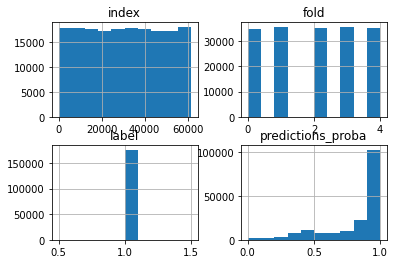

In [ ]:
train_df[train_df.label==True].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe33c99f40>,
      dtype=object)

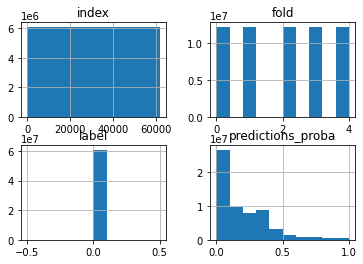

In [ ]:
train_df[train_df.label==False].hist()

In [ ]:
oof_df = train_df
del train_df
gc.collect()

45

In [ ]:
oof_df.loc[oof_df.predictions_proba>=0.95, 'pred'] = 1
oof_df.loc[oof_df.predictions_proba<0.95, 'pred'] = 0 

In [ ]:
oof_df

,index,content_id,topic_id,fold,label,predictions_proba,pred
0,4,c_98a3be795988,t_0008768bdee6,1,0,0.947986,0.0
1,4,c_15dbfe4c4b7f,t_0008768bdee6,1,0,0.981637,1.0
2,4,c_a054a9c041a7,t_0008768bdee6,1,0,0.995312,1.0
3,4,c_179302899cfc,t_0008768bdee6,1,0,0.976673,1.0
4,4,c_bf882e1890d5,t_0008768bdee6,1,0,0.796675,0.0
...,...,...,...,...,...,...,...
60912969,61516,c_e16b0d8f675c,t_fffe811a6da9,2,0,0.097171,0.0
60912970,61516,c_e052cc1dc588,t_fffe811a6da9,2,0,0.097171,0.0
60912971,61516,c_b422faa91aae,t_fffe811a6da9,2,0,0.097171,0.0
60912972,61516,c_4f45f4a2260f,t_fffe811a6da9,2,0,0.097171,0.0


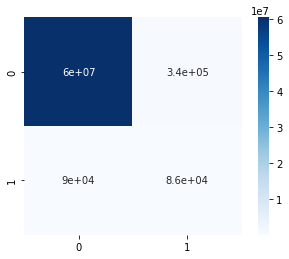

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(oof_df.label, oof_df.pred)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')

In [ ]:
def postprocess(df, threshold: float=0.95, top_n: int = 5):
  df.loc[df.predictions_proba>=threshold, 'pred'] = 1
  df.loc[df.predictions_proba<threshold, 'pred'] = 0 
  result = []
  grouped_df = df.groupby('topic_id')
  for idx, df_ in tqdm.tqdm(grouped_df, total=len(grouped_df)):
    if df_.pred.sum()==0:
      res_df = df_.iloc[:top_n]
    else:
      res_df = df_[df_.pred==True]
    result.append(res_df.loc[:,['topic_id', 'content_id']])
  result = pd.concat(result, axis=0)
  result = pd.DataFrame(result.groupby('topic_id').apply(lambda x:' '.join(x.content_id)))
  result =result.reset_index().rename(columns={0:'content_ids'})
  result['content_ids'] = result['content_ids'].apply(lambda x:' '.join(x.split(' ')))
  return result

In [ ]:
result = postprocess(oof_df)

100%|██████████| 61512/61512 [01:00<00:00, 1015.94it/s]


In [ ]:
result

,topic_id,content_ids
0,t_0008768bdee6,c_15dbfe4c4b7f c_a054a9c041a7 c_179302899cfc c...
1,t_0008a1bd84ba,c_7ff92a954a3d
2,t_000d1fb3f2f5,c_d7b213393f30 c_9fe86abded70 c_55e7244b3fea c...
3,t_000feba42136,c_304ee4f59410
4,t_00102869fbcb,c_d2cf189bb4ac c_af02c8d450c5 c_8453fab783ce
...,...,...
61507,t_fff830472691,c_61fb63326e5d c_8f224e321c87
61508,t_fff9e5407d13,c_e40fd6243440 c_d64037a72376 c_20de77522603 c...
61509,t_fffbe1d5d43c,c_46f852a49c08 c_6659207b25d5
61510,t_fffe14f1be1e,c_f28704d03be0


In [ ]:
target_df = correlations_df[correlations_df.topic_id.isin(result.topic_id)].reset_index(drop=True)

In [ ]:
from sklearn.metrics import fbeta_score
import numpy as np

def calc_f2_score(true_ids, pred_ids):
  true_positives = len(set(true_ids)&set(pred_ids))
  false_positives = len(set(pred_ids)-set(true_ids))
  false_negatives = len(set(true_ids)-set(pred_ids))

  beta = 2
  f2_score = ((1+beta**2)*true_positives)/((1+beta**2)*true_positives + beta**2*false_negatives + false_positives)
  return f2_score

def calc_f2_score_mean(target_df, pred_df):
  shape = target_df.shape
  score = [calc_f2_score(target_df.loc[i, 'content_ids'].split(), pred_df.loc[i, 'content_ids'].split()) for i in range(shape[0])]
  target_df['f2_score'] = score
  return target_df['f2_score'].mean(), target_df

In [ ]:
calc_f2_score_mean(target_df, result)

(0.334558512812328,
              topic_id                                        content_ids  \
 0      t_0008768bdee6       c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4   
 1      t_0008a1bd84ba                      c_7ff92a954a3d c_8790b074383e   
 2      t_000d1fb3f2f5  c_07f1d0eec4b2 c_15a6fb858696 c_175e9db3fc44 c...   
 3      t_000feba42136                      c_2bbc650030f4 c_304ee4f59410   
 4      t_00102869fbcb  c_005e793bd0c5 c_066737fa5146 c_08b2070f92e0 c...   
 ...               ...                                                ...   
 61507  t_fff830472691                      c_61fb63326e5d c_8f224e321c87   
 61508  t_fff9e5407d13  c_026db653a269 c_0fb048a6412c c_20de77522603 c...   
 61509  t_fffbe1d5d43c                      c_46f852a49c08 c_6659207b25d5   
 61510  t_fffe14f1be1e                                     c_cece166bad6a   
 61511  t_fffe811a6da9                                     c_92b8fad372ee   
 
        f2_score  
 0      0.227273  
 1      0.555556

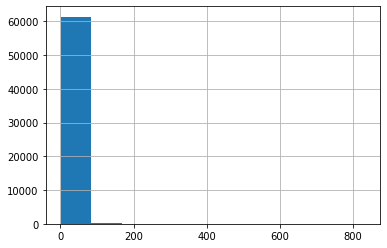

In [ ]:
result.content_ids.apply(lambda x:len(x.split(' '))).hist()

In [ ]:
topics_df

,id,title,language,fold
0,t_00004da3a1b2,Откриването на резисторите,bg,-1
1,t_00068291e9a4,Entradas e saídas de uma função,pt,-1
2,t_00069b63a70a,Transcripts,en,-1
3,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,bg,-1
4,t_0008768bdee6,100 સુધીનો સરવાળો,gu,1
...,...,...,...,...
61512,t_fff830472691,Scalar Projections,en,2
61513,t_fff9e5407d13,NA_U06 - El periódico,es,4
61514,t_fffbe1d5d43c,Inscribed shapes problem solving,sw,2
61515,t_fffe14f1be1e,Lección 7,es,2


In [ ]:
calc_f2_score_mean(correlations_df, oof_prd_2)

(0.29761578097290853,
              topic_id                                        content_ids  \
 0      t_00004da3a1b2  c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...   
 1      t_00068291e9a4  c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...   
 2      t_00069b63a70a                                     c_11a1dc0bfb99   
 3      t_0006d41a73a8  c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...   
 4      t_0008768bdee6       c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4   
 ...               ...                                                ...   
 61512  t_fff830472691                      c_61fb63326e5d c_8f224e321c87   
 61513  t_fff9e5407d13  c_026db653a269 c_0fb048a6412c c_20de77522603 c...   
 61514  t_fffbe1d5d43c                      c_46f852a49c08 c_6659207b25d5   
 61515  t_fffe14f1be1e                                     c_cece166bad6a   
 61516  t_fffe811a6da9                                     c_92b8fad372ee   
 
        f2_score  
 0      0.000000  
 1      0.2380

In [ ]:
correlations_df.loc[correlations_df.topic_id.isin(oof_prd.topic_id), 'pred_svm']=True
correlations_df['pred_svm']=correlations_df['pred_svm'].fillna(False)